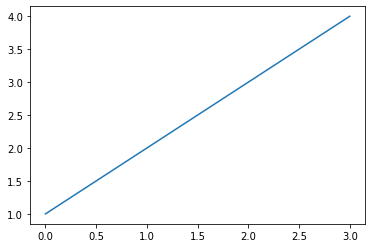

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

In [3]:
import re
import torchtext.data  
import numpy as np
import pandas as pd
import string

In [4]:
from torchtext.vocab import FastText as ft
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.transforms import ToTensor
from torchtext.vocab import Vectors

In [5]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [61]:
torch.cuda.init()

In [62]:
torch.cuda.is_initialized()

True

In [8]:
import unicodedata

In [9]:
import spacy

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
from torchtext import data,datasets

In [12]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [13]:
with open(r'C:\Users\niels\OneDrive\data_1\train\nietzsche.txt','r',encoding='utf-8') as f:
    text = f.read()

In [14]:
split = text.split('.')

In [15]:
nietzsche = [normalize_string(q) for q in split]

In [16]:
nietzsche

['preface supposing that truth is a woman what then ? is there not ground for suspecting that all philosophers in so far as they have been dogmatists have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth have been unskilled and unseemly methods for winning a woman ? certainly she has never allowed herself to be won and at present every kind of dogma stands with sad and discouraged mien if indeed it stands at all ! for there are scoffers who maintain that it has fallen that all dogma lies on the ground nay more that it is at its last gasp',
 'but to speak seriously there are good grounds for hoping that all dogmatizing in philosophy whatever solemn whatever conclusive and decided airs it has assumed may have been only a noble puerilism and tyronism and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute philos

In [17]:
t = get_tokenizer(None, language='en')

In [18]:
tokens = []
for sen in nietzsche:
    tokens.extend(t(sen))

In [19]:
len(tokens)

101848

In [20]:
class Vocab:
    def __init__(self, name):
        self.name = name
        self.stoi = {}
        self.word2count = {}
        self.itos = {}
        self.n_words = 0

    def add_sentence(self, sentence):
        for w in sentence.split(' '):
            self.add_word(w)

    def add_word(self, w):
        if w not in self.stoi:
            self.itos[self.n_words] = w
            self.stoi = {w:i for (i,w) in self.itos.items()}
            self.word2count[w] = 1 
            self.n_words += 1
        else:
            self.word2count[w] += 1

In [21]:
vocab = Vocab('en')

In [22]:
for l in nietzsche:
    vocab.add_sentence(l)

In [23]:
inputs = [[vocab.stoi[y] for y in t(l)] for l in nietzsche]

In [111]:
concatenated_text = []
for l in inputs:
    concatenated_text.extend(l)

In [115]:
text_tensor = torch.tensor(concatenated_text)

In [117]:
chunk_size=128

In [119]:
chunks = text_tensor.chunk(text_tensor.size(0)//chunk_size)

In [122]:
chunks = chunks[:-1]

In [123]:
t = torch.stack(chunks)

In [124]:
ds = TensorDataset(t)

In [206]:
tensorizer = ToTensor(padding_value=1)

In [207]:
tensors = tensorizer(inputs)

C:\Users\niels\anaconda3\envs\ai\lib\site-packages\torch\_jit_internal.py:1138: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn("The inner type of a container is lost when "


In [208]:
tensors.size()

torch.Size([2788, 588])

In [209]:
tensor_ds = TensorDataset(tensors)

In [125]:
class MaskedCausalAttention(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads
        self.max_T = max_T

        self.q_net = nn.Linear(h_dim, h_dim)
        self.k_net = nn.Linear(h_dim, h_dim)
        self.v_net = nn.Linear(h_dim, h_dim)

        self.proj_net = nn.Linear(h_dim, h_dim)

        self.att_drop = nn.Dropout(drop_p)
        self.proj_drop = nn.Dropout(drop_p)

        ones = torch.ones((max_T, max_T))
        mask = torch.tril(ones).view(1, 1, max_T, max_T)

        # register buffer makes sure mask does not get updated
        # during backpropagation
        self.register_buffer('mask',mask)

    def forward(self, x):
        B, T, C = x.shape # batch size, seq length, h_dim

        N, D = self.n_heads, C//self.n_heads # N = num heads, D = attention dim

        # rearrange q, k, v as (B, N, T, D)
        q = self.q_net(x).view(B, T, N, D).transpose(1,2)
        k = self.k_net(x).view(B, T, N, D).transpose(1,2)
        v = self.v_net(x).view(B, T, N, D).transpose(1,2)

        # weights (B, N, T, T)
        weights = q @ k.transpose(2,3) / math.sqrt(D)
        # causal mask applied to weights
        weights = weights.masked_fill(self.mask[...,:T,:T] == 0, float('-inf'))
        # normalize weights, all -inf -> 0 after softmax
        normalized_weights = F.softmax(weights, dim=-1)

        # attention (B, N, T, D)
        attention = self.att_drop(normalized_weights @ v)

        # gather heads and project (B, N, T, D) -> (B, T, N*D)
        attention = attention.transpose(1, 2).contiguous().view(B,T,N*D)

        out = self.proj_drop(self.proj_net(attention))
        return out


In [126]:
class Block(nn.Module):

    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()

        self.attention = MaskedCausalAttention(h_dim, max_T, n_heads, drop_p)

        self.mlp = nn.Sequential(
            nn.Linear(h_dim, 4*h_dim),
            nn.GELU(),
            nn.Linear(4*h_dim, h_dim),
            nn.Dropout(drop_p),
        )

        self.ln1 = nn.LayerNorm(h_dim)
        self.ln2 = nn.LayerNorm(h_dim)

    def forward(self, x):
        # Attention -> LayerNorm -> MLP -> LayerNorm

        x = x + self.attention(x) # residual
        x = self.ln1(x) 
        x = x + self.mlp(x) # residual
        x = self.ln2(x)
        return x


In [127]:
class GPT(nn.Module):

    def __init__(self, token_dim, n_blocks, h_dim, max_T, n_heads, drop_p):
        super().__init__()
    
        # embed input tokens and positions
        self.proj_token = nn.Embedding(token_dim, h_dim)
        # parameter = trainable weight matrix 
        init_param_vals = torch.randn(1, max_T, h_dim) / math.sqrt(h_dim)
        self.position_embedding = nn.Parameter(init_param_vals)
        self.dropout = nn.Dropout(drop_p)

        # transformer blocks
        blocks = [Block(h_dim, max_T, n_heads, drop_p) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)

        # projection head
        self.ln = nn.LayerNorm(h_dim)
        self.proj_head = nn.Linear(h_dim, token_dim)

    def forward(self, x):
        B, T = x.shape 

        # token and pos embedding
        token_h = self.proj_token(x)
        pos_h = self.position_embedding[:, :T, :]
        h = token_h + pos_h

        # transformer and prediction
        h = self.ln(self.transformer(h))
        pred = self.proj_head(h)

        return pred
    
    def pred_loss(self,pred,target):
        B, T,_ = pred.shape

        return nn.CrossEntropyLoss()(pred.reshape(B*T,-1),target.reshape(-1))


In [210]:
model = GPT(len(vocab.stoi),6,300,600,6,0.1).cuda()

In [211]:
batch_size =32

In [212]:
dl = DataLoader(ds,batch_size,shuffle=True)

In [219]:
optimizer = Adam(model.parameters(),lr=0.00001)

In [214]:
def train_epoch(model, train_dl, optimizer):
    model.train()
    losses = 0
    for idx, x in enumerate(train_dl):
        
        x = x[0].cuda()


        loss = model.pred_loss(model(x),x)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        losses += loss.item()
        if idx % 100 == 0:
            print(loss.item())

    return losses / len(train_dl)

        

In [215]:
epoch_losses = []
epochs = 100
for _ in range(epochs):
    loss = train_epoch(model,dl,optimizer)
    epoch_losses.append(loss)    

9.382904052734375
5.585963726043701
4.41486120223999
3.5431418418884277
3.068905830383301
2.6873388290405273
2.3572800159454346
2.1679344177246094
1.9614005088806152
1.8458129167556763
1.7692515850067139
1.6052645444869995
1.4889450073242188
1.3363118171691895
1.2324923276901245
1.1623731851577759
1.1897629499435425
0.9983491897583008
0.9923701286315918
0.8709816336631775
0.8284129500389099
0.8037646412849426
0.7321604490280151
0.6661989688873291
0.6623449325561523
0.6770723462104797
0.5896052718162537
0.4941532015800476
0.5083661675453186
0.44068318605422974
0.4747692346572876
0.46176663041114807
0.4146486520767212
0.37540361285209656
0.34931835532188416
0.3816624879837036
0.3246583938598633
0.30392250418663025
0.3360211253166199
0.26574021577835083
0.26648715138435364
0.2229602187871933
0.21112041175365448
0.20697641372680664
0.17710401117801666
0.1862054467201233
0.1537965089082718
0.1352362036705017
0.1404375433921814
0.1399403214454651
0.1328653246164322
0.1172497496008873
0.09648

GPT(
  (proj_token): Embedding(9877, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Sequential(
    (0): Block(
      (attention): MaskedCausalAttention(
        (q_net): Linear(in_features=300, out_features=300, bias=True)
        (k_net): Linear(in_features=300, out_features=300, bias=True)
        (v_net): Linear(in_features=300, out_features=300, bias=True)
        (proj_net): Linear(in_features=300, out_features=300, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=1200, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=1200, out_features=300, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (attention): MaskedCausalAtt

In [220]:
dl1 = DataLoader(tensor_ds,batch_size=16,shuffle=True)

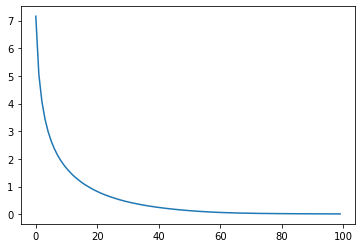

In [170]:
plt.plot(epoch_losses)

In [192]:
def predict_next_word(s):    
    tokens = [vocab.stoi[w] for w in s.split(' ')]
    b = torch.LongTensor(tokens).unsqueeze(0).cuda()
    top_tokens = torch.topk(F.softmax(model(b),dim=2)[:,-1,:],5,dim=1)[1].cpu().numpy()[0]
    t = np.random.choice(top_tokens)
    return vocab.itos[t]

In [193]:
s = 'get me a '

In [198]:
predict_next_word(s)

'desirability'

In [196]:
    tokens = [vocab.stoi[w] for w in s.split(' ')]
    b = torch.LongTensor(tokens).unsqueeze(0).cuda()

In [181]:
top_tokens = torch.topk(F.softmax(model(b),dim=2)[:,-1,:],5,dim=1)[1].cpu().numpy()[0]

In [182]:
for t in top_tokens:
    print('get me a '+ vocab.itos[t])

get me a oppression
get me a collective
get me a desirability
get me a swayed
get me a wilderness


In [203]:
def fine_tune_epoch(model, train_dl, optimizer):
    model.train()
    losses = 0
    for idx, x in enumerate(train_dl):
        
        x = x[0].cuda()
        
        pred = model(x[:,:-1])
        target = x[:,1:]


        loss = model.pred_loss(pred,target)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        losses += loss.item()
        if idx % 100 == 0:
            print(loss.item())

    return losses / len(train_dl)

In [221]:
epoch_losses = []
epochs = 100
for _ in range(epochs):
    loss = fine_tune_epoch(model,dl1,optimizer)
    epoch_losses.append(loss) 

0.1977980136871338
0.27969905734062195
0.2818354368209839
0.2856348752975464
0.2904786765575409
0.35840752720832825
0.17762865126132965
0.30619171261787415
0.11325746774673462
0.3366066515445709
0.30604755878448486
0.25424063205718994
0.31192412972450256
0.2455051839351654
0.286969929933548
0.19287413358688354
0.2541009783744812
0.19767537713050842
0.39499354362487793
0.2631813585758209
0.4757448732852936
0.30536171793937683
0.24078023433685303
0.4116151034832001
0.2070976197719574
0.3145284354686737
0.20463673770427704
0.20790338516235352
0.38805609941482544
0.16433611512184143
0.18221980333328247
0.20326508581638336
0.2515687942504883
0.2484237402677536
0.16281722486019135
0.3185081481933594
0.2393372505903244
0.2768155038356781
0.21928787231445312
0.34189748764038086
0.3288831412792206
0.22964267432689667
0.32576629519462585
0.2527076303958893
0.22746901214122772
0.5250949263572693
0.3238487243652344
0.11440813541412354
0.3229316174983978
0.23053187131881714
0.32822707295417786
0.21

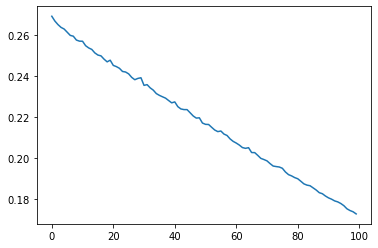

In [222]:
plt.plot(epoch_losses)

In [74]:
model.train(False)

GPT(
  (proj_token): Embedding(9877, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Sequential(
    (0): Block(
      (attention): MaskedCausalAttention(
        (q_net): Linear(in_features=300, out_features=300, bias=True)
        (k_net): Linear(in_features=300, out_features=300, bias=True)
        (v_net): Linear(in_features=300, out_features=300, bias=True)
        (proj_net): Linear(in_features=300, out_features=300, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=1200, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=1200, out_features=300, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (attention): MaskedCausalAtt

In [223]:
def predict_next_word(s):    
    tokens = [vocab.stoi[w] for w in s.split(' ')]
    b = torch.LongTensor(tokens).unsqueeze(0).cuda()
    model_pred = model(b).argmax(dim=2).cpu().detach().numpy()[0][-1]
    word = vocab.itos[model_pred]
    return word

In [224]:
predict_next_word('get me a')

'strong'

In [225]:
def extend_sentence(s,n):
    for _ in range(n):
        t = predict_next_word(s)
        s = s + ' ' + t
    return s
    

In [241]:
extend_sentence('but is that an answer ?',50)

'but is that an answer ? a sort of the individual ? and the germans is ? for truth is it is it is something that it not the things may be a very few to be the manifestation of the thing is that it not different ? in europe the thing ? in the case'